<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Required Libraries and Modules</h2>
</div>

**Note: This notebook is run in Paperspace platform**

In [1]:
!pip install transformers
!pip install torch
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 20.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.2/763.2 KB 8.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 KB 197.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 24.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 23.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 32.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, classification_report

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback, set_seed

# Progress bar
from tqdm._tqdm_notebook import tqdm_notebook
from tqdm import tqdm
tqdm_notebook.pandas()

/tmp/ipykernel_52/491656687.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Import Clean Text Data</h2>
</div>

In [3]:
###############################################################
# Note: Change the name of data set used for feature creation
###############################################################
data_set='bully_data_clean_with_stopword'
    
    
###################
# Import Data Set #
###################
bully_data_cleaned = pd.read_csv('/datasets/data/bully_data_clean_with_stopword_short.csv', encoding='utf8')                                            
bully_data_cleaned = bully_data_cleaned[~bully_data_cleaned['text_check'].isna()]
bully_data_cleaned = bully_data_cleaned[bully_data_cleaned['text_check'] != ""]
#bully_data_cleaned = bully_data_cleaned[bully_data_cleaned['role']!='None']
bully_data_cleaned = bully_data_cleaned[['label','text_check']]
bully_data_cleaned['label'] = bully_data_cleaned['label'].progress_apply(lambda x: 1 if x =="Cyberbullying" else 0)
bully_data_cleaned.rename(columns = {'text_check':'text'}, inplace = True)
bully_data_cleaned = bully_data_cleaned.reset_index(drop=True)

  0%|          | 0/112247 [00:00<?, ?it/s]

In [4]:
bully_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112247 entries, 0 to 112246
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   112247 non-null  int64 
 1   text    112247 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [5]:
bully_data_cleaned['label'].value_counts()

0    106872
1      5375
Name: label, dtype: int64

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Define pretrained tokenizer and model</h2>
</div>
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# Define pretrained tokenizer and model

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# def model_init():
#     return AutoModelForSequenceClassification.from_pretrained(model_name, 
#                                                               num_labels=2, 
#                                                             output_attentions = False, # Whether the model returns attentions weights.
#                                                             output_hidden_states = False,
#                                                             return_dict=True )
set_seed(1127)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Preprocess data and Fine Tune Transformers</h2>
</div>

In [7]:
##############################
# Data: Text Input and Label #
##############################
X = list(bully_data_cleaned["text"])
y = list(bully_data_cleaned["label"])


########################
# Create torch dataset #
########################
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


#############################
# Define Trainer parameters #
#############################
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall_cb = recall_score(y_true=labels, y_pred=pred, average='binary', pos_label=1)
    precision_cb = precision_score(y_true=labels, y_pred=pred, average='binary', pos_label=1)
    f1_cb = f1_score(y_true=labels, y_pred=pred, average='binary', pos_label=1)
    
    recall_ncb = recall_score(y_true=labels, y_pred=pred, average='binary', pos_label=0)
    precision_ncb = precision_score(y_true=labels, y_pred=pred, average='binary', pos_label=0)
    f1_ncb = f1_score(y_true=labels, y_pred=pred, average='binary', pos_label=0)
    
    recall_overall = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision_overall = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1_overall = f1_score(y_true=labels, y_pred=pred, average='macro')


    return {"accuracy": accuracy, 
            "precision_cb": precision_cb, "recall_cb": recall_cb, "f1_cb": f1_cb,
            "precision_ncb": precision_ncb, "recall_ncb": recall_ncb, "f1_ncb": f1_ncb,
            "precision_overall": precision_overall, "recall_overall": recall_overall, "f1_overall": f1_overall}


#########################
# Plot Confusion Matrix #
#########################
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CONFUSION MATRIX IN PERCENTAGE
    cf_pct = cf.astype('float')/cf.sum(axis=1)[:, np.newaxis]
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf_pct.flatten()]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf_pct,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


########################
# Run cross-validation #
########################
def run_cross_validation(model_name='DistilBert',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=False):
    
    kfold = StratifiedShuffleSplit(n_splits=splits, test_size=0.1, random_state=1127)    
    # kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=1127)
    n_fold = 1

    print("Developing Model with Cross validation for: " + model_name)
    for train, test in tqdm(kfold.split(X, y)):

        print("Running for Fold: ",n_fold)
        train_index = list(train)
        test_index = list(test)

        X_train = [X[i] for i in train_index]
        y_train = [y[i] for i in train_index]
        X_val = [X[i] for i in test_index]
        y_val = [y[i] for i in test_index]

        # Tokenize
        X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
        X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

        # Create torch dataset
        train_dataset = Dataset(X_train_tokenized, y_train)
        val_dataset = Dataset(X_val_tokenized, y_val)

        # Fine Tune Transformer
        # Define Trainer
        args = TrainingArguments(
            output_dir="content/drive/MyDrive_binary/output_" + model_name + "/fold"+str(n_fold),
            evaluation_strategy="epoch",
            save_strategy="epoch",
            #eval_steps=500,
            #per_device_train_batch_size=1,
            #per_device_eval_batch_size=1,
            num_train_epochs=epoch, #1 was okay
            seed=1127,
            load_best_model_at_end=True,
        )

        trainer = Trainer(
        #model_init=model_init,
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        )
        
        if n_fold <=4:
            checkpoint_temp=True
        else:
            checkpoint_temp=False

        trainer.train(resume_from_checkpoint=checkpoint)
        print("Complete for fold", n_fold)
        n_fold= n_fold + 1


#####################
# Run Hold Out Test #
#####################

# Train and Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1127)

# Train and Validate Set
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=1127)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_test)

def run_hold_out_split(model_name='DistilBert',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=False):
  
    print("Developing Model with Hold Out Splits for: " + model_name)
    # Fine Tune Transformer
    # Define Trainer
    args = TrainingArguments(
      output_dir="content/drive/MyDrive_binary/output_" + model_name + "/holdout",
      evaluation_strategy="epoch",
      save_strategy="epoch",
      #eval_steps=500,
      #per_device_train_batch_size=1,
      #per_device_eval_batch_size=1,
      num_train_epochs=epoch, #1 was okay
      seed=1127,
      load_best_model_at_end=True,
    )

    trainer = Trainer(
    # model_init=model_init,
    args=args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    )

    trainer.train(resume_from_checkpoint=checkpoint)
    print("Complete for hold-out validate set")


In [8]:
###########################
# Predict (Hold Out Test) #
###########################

from sklearn.metrics import confusion_matrix
def compute_metrics_holdout(model_name='DistilBert',
                            model_path='content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-3820', 
                            average_method='binary',
                            X_test=X_test):
  
    X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

    # Create torch dataset
    test_dataset = Dataset(X_test_tokenized)

    # Load trained model
    model_pred = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)

    # Define test trainer
    test_trainer = Trainer(model_pred)

    # Make prediction
    raw_pred, _, _ = test_trainer.predict(test_dataset)

    # Preprocess raw predictions
    y_pred = np.argmax(raw_pred, axis=1)

    # Compute metrics
    precision_cb = precision_score(y_test, y_pred, average=average_method, pos_label=1)
    recall_cb = recall_score(y_test, y_pred, average=average_method, pos_label=1)
    f1_cb = f1_score(y_test, y_pred, average=average_method, pos_label=1)

    precision_ncb = precision_score(y_test, y_pred, average=average_method, pos_label=0)
    recall_ncb = recall_score(y_test, y_pred, average=average_method, pos_label=0)
    f1_ncb = f1_score(y_test, y_pred, average=average_method, pos_label=0)

    precision_overall = precision_score(y_test, y_pred, average='macro')
    recall_overall = recall_score(y_test, y_pred, average='macro')
    f1_overall = f1_score(y_test, y_pred, average='macro')

    # Print Results
    print("Classification Report:")
    print(classification_report(y_test,y_pred))
    print()
    print("Label 1: Cyberbullying")
    print("Precision: ", precision_cb)
    print("Recall: ", recall_cb)
    print("F-measure: ", f1_cb)
    print()
    print("Label 0: Non-Cyberbullying")
    print("Precision: ", precision_ncb)
    print("Recall: ", recall_ncb)
    print("F-measure: ", f1_ncb)
    print()
    print("Macro Metrics")
    print("Precision: ", precision_overall)
    print("Recall: ", recall_overall)
    print("F-measure: ", f1_overall)
    print()

    # Confusion Matrix
    conf_mat = confusion_matrix(y_test,y_pred)
    categories = ['Non-Cyberbullying', 'Cyberbullying']
    labels = ['True Negative','',
            '','True Positive']

    make_confusion_matrix(conf_mat, 
                        group_names=labels,
                        categories=categories, 
                        figsize=(8,5), 
                        cbar=True, 
                        title='Fine Tuned ' + model_name + ' for Cyberbullying Detection', 
                        cmap='YlGnBu', 
                        sum_stats=False)



<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Cross Validation (K = 5)</h2>
</div>

In [ ]:
run_cross_validation(model_name='DistilBert',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=4,
                         checkpoint=False)

Developing Model with Cross validation for: DistilBert


0it [00:00, ?it/s]

Running for Fold:  1


/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.122400,0.139942,0.961960,0.669725,0.407063,0.506358,0.970729,0.989894,0.980218,0.820227,0.698479,0.743288
2,0.133800,0.156808,0.964098,0.724252,0.405204,0.519666,0.970707,0.992234,0.981352,0.847480,0.698719,0.750509
3,0.110400,0.134533,0.965167,0.733333,0.429368,0.541618,0.971861,0.992140,0.981896,0.852597,0.710754,0.761757
4,0.093800,0.153179,0.963029,0.642691,0.514870,0.571723,0.975820,0.985590,0.980681,0.809256,0.750230,0.776202


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-12628/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-25256
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-25256/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-25256/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-37884
Configuration saved in content/drive/MyDrive_binary/output_Disti

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.117100,0.137941,0.968731,0.741602,0.533457,0.620541,0.976841,0.990643,0.983693,0.859221,0.762050,0.802117
2,0.117000,0.126553,0.968641,0.718310,0.568773,0.634855,0.978517,0.988771,0.983617,0.848413,0.778772,0.809236


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-12628/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-25256
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-25256/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-25256/pytorch_model.bin


### [Continue] Cross Validation (K = 5)

In [ ]:
run_cross_validation(model_name='DistilBert',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=4,
                         checkpoint=True)

Developing Model with Cross validation for: DistilBert


0it [00:00, ?it/s]

Running for Fold:  1


Loading model from content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 4
  Continuing training from global step 50512
  Will skip the first 4 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the trai

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-37884 (score: 0.1345326006412506).


Epoch,Training Loss,Validation Loss


1it [00:24, 24.01s/it]

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-25256).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512
  Continuing training from checkpoint, will skip to s

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
3,0.105500,0.125980,0.968374,0.727047,0.544610,0.622742,0.977361,0.989707,0.983495,0.852204,0.767158,0.803119
4,0.075800,0.138436,0.968285,0.726368,0.542751,0.621277,0.977271,0.989707,0.983450,0.851819,0.766229,0.802363


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-37884
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-37884/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-37884/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-50512
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-50512/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-50512/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-37884 (score: 0.12597954273223877).
2it [1:31:57, 3241.38s

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.105200,0.132810,0.973274,0.841954,0.544610,0.661400,0.977475,0.994854,0.986088,0.909715,0.769732,0.823744
2,0.080500,0.111856,0.976570,0.799564,0.682156,0.736209,0.984117,0.991391,0.987741,0.891840,0.836774,0.861975
3,0.081400,0.101646,0.976481,0.795259,0.685874,0.736527,0.984295,0.991111,0.987691,0.889777,0.838492,0.862109
4,0.071200,0.106964,0.976303,0.814815,0.654275,0.725773,0.982767,0.992514,0.987616,0.898791,0.823395,0.856695


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-12628/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-25256
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-25256/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-25256/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-37884
Configuration saved in content/drive/MyDrive_binary/output_Disti

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.104000,0.114283,0.973719,0.727955,0.721190,0.724556,0.985971,0.986432,0.986201,0.856963,0.853811,0.855379


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-12628/pytorch_model.bin


### [Continue] Cross Validation (K = 5)

In [9]:
run_cross_validation(model_name='DistilBert',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=4,
                         checkpoint=True)

Developing Model with Cross validation for: DistilBert


0it [00:00, ?it/s]

Running for Fold:  1


Loading model from content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 4
  Continuing training from global step 50512
  Will skip the first 4 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the trai

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-37884 (score: 0.1345326006412506).


Epoch,Training Loss,Validation Loss


1it [00:22, 22.45s/it]

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512
  Continuing training from checkpoint, will skip to s

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-37884 (score: 0.12597954273223877).


Epoch,Training Loss,Validation Loss


2it [00:45, 22.69s/it]

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512
  Continuing training from checkpoint, will skip to s

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-37884 (score: 0.10164638608694077).


Epoch,Training Loss,Validation Loss


3it [01:04, 21.07s/it]

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-12628).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512
  Continuing training from checkpoint, will skip to s

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
2,0.090400,0.097298,0.976927,0.781818,0.719331,0.749274,0.985927,0.989894,0.987907,0.883873,0.854613,0.868590
3,0.094700,0.101130,0.977372,0.815556,0.682156,0.742915,0.984130,0.992234,0.988165,0.899843,0.837195,0.865540
4,0.057900,0.101350,0.977550,0.802966,0.704461,0.750495,0.985213,0.991298,0.988246,0.894090,0.847879,0.869371


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-25256
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-25256/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-25256/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-37884
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-37884/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-37884/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-50512
Configuration saved in content/drive/MyDrive_binary/output_Disti

Complete for fold 4
Running for Fold:  5


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.106400,0.112681,0.975947,0.778008,0.697026,0.735294,0.984827,0.989988,0.987401,0.881418,0.843507,0.861347
2,0.095300,0.127457,0.971047,0.801700,0.526022,0.635241,0.976545,0.993450,0.984925,0.889122,0.759736,0.810083
3,0.066200,0.124312,0.974878,0.781938,0.659851,0.715726,0.983010,0.990736,0.986858,0.882474,0.825294,0.851292
4,0.073000,0.108755,0.975768,0.792952,0.669145,0.725806,0.983474,0.991204,0.987324,0.888213,0.830175,0.856565


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-12628/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-25256
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-25256/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-25256/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-37884
Configuration saved in content/drive/MyDrive_binary/output_Disti

Complete for fold 5


### [Continue] Cross Validation (K = 5)

In [ ]:
run_cross_validation(model_name='DistilBert',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=True)

Developing Model with Cross validation for: DistilBert


0it [00:00, ?it/s]

Running for Fold:  1


Loading model from content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 4
  Continuing training from global step 50512
  Will skip the first 4 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the tra

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
5,0.092200,0.151382,0.963831,0.675532,0.472119,0.555799,0.973822,0.988584,0.981148,0.824677,0.730352,0.768473
6,0.088300,0.177724,0.964811,0.674817,0.513011,0.582893,0.975777,0.987555,0.981630,0.825297,0.750283,0.782262
7,0.086600,0.178357,0.965256,0.716374,0.455390,0.556818,0.973077,0.990924,0.981919,0.844726,0.723157,0.769369


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-63140
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-63140/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-63140/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-75768
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-75768/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-75768/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-88396
Configuration saved in content/drive/MyDrive_binary/output_Disti

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
5,0.105600,0.142114,0.967661,0.703963,0.561338,0.624612,0.978140,0.988116,0.983103,0.841051,0.774727,0.803858
6,0.071600,0.165928,0.967216,0.704327,0.544610,0.614256,0.977334,0.988491,0.982881,0.840830,0.766550,0.798568
7,0.075400,0.169131,0.966414,0.726761,0.479554,0.577828,0.974241,0.990924,0.982511,0.850501,0.735239,0.780170


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-63140
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-63140/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-63140/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-75768
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-75768/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-75768/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-88396
Configuration saved in content/drive/MyDrive_binary/output_Disti

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss


### [Continue] Cross Validation (K = 5)

In [ ]:
run_cross_validation(model_name='DistilBert',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=True)

Developing Model with Cross validation for: DistilBert


0it [00:00, ?it/s]

Running for Fold:  1


Loading model from content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-88396).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 7
  Continuing training from global step 88396
  Will skip the first 7 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the tra

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
8,0.056800,0.172492,0.965969,0.696970,0.513011,0.591006,0.975806,0.988771,0.982246,0.836388,0.750891,0.786626


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-101024
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-101024/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-101024/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-37884 (score: 0.1345326006412506).
1it [44:07, 2647.66s/it]

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-88396).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
8,0.082100,0.167790,0.967751,0.716749,0.540892,0.616525,0.977170,0.989239,0.983167,0.846959,0.765066,0.799846


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-101024
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-101024/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-101024/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-37884 (score: 0.12597954273223877).
2it [1:28:50, 2668.07s/it]

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
5,0.085300,0.119958,0.975590,0.840206,0.605948,0.704104,0.980437,0.994199,0.987270,0.910322,0.800073,0.845687
6,0.061400,0.115216,0.973898,0.763441,0.659851,0.707876,0.982993,0.989707,0.986338,0.873217,0.824779,0.847107
7,0.066500,0.124619,0.972561,0.712177,0.717472,0.714815,0.985772,0.985403,0.985587,0.848974,0.851437,0.850201


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-63140
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-63140/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-63140/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-75768
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-75768/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-75768/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-88396
Configuration saved in content/drive/MyDrive_binary/output_Disti

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
5,0.082200,0.116181,0.976214,0.790150,0.685874,0.734328,0.984291,0.990830,0.987550,0.887220,0.838352,0.860939
6,0.065500,0.104178,0.975412,0.799087,0.650558,0.717213,0.982572,0.991766,0.987147,0.890829,0.821162,0.852180


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-63140
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-63140/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-63140/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-75768
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-75768/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-75768/pytorch_model.bin


### [Continue] Cross Validation (K = 5)

In [9]:
run_cross_validation(model_name='DistilBert',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=True)

Developing Model with Cross validation for: DistilBert


0it [00:00, ?it/s]

Running for Fold:  1


Loading model from content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 8
  Continuing training from global step 101024
  Will skip the first 8 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the t

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-37884 (score: 0.1345326006412506).


Epoch,Training Loss,Validation Loss


1it [00:25, 25.01s/it]

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-37884 (score: 0.12597954273223877).


Epoch,Training Loss,Validation Loss


2it [00:47, 23.53s/it]

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-88396).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
8,0.069400,0.126799,0.973185,0.730994,0.697026,0.713606,0.984783,0.987087,0.985934,0.857889,0.842057,0.849770


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-101024
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-101024/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-101024/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-37884 (score: 0.10164638608694077).
3it [46:55, 1276.78s/it]

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-75768).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
7,0.056900,0.111430,0.975947,0.796460,0.669145,0.727273,0.983477,0.991391,0.987418,0.889969,0.830268,0.857346
8,0.044800,0.122205,0.975323,0.794582,0.654275,0.717635,0.982749,0.991485,0.987098,0.888666,0.822880,0.852366


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-88396
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-88396/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-88396/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-101024
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-101024/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-101024/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-25256 (score: 0.09729836136102676).
4it [2:18:04, 2931.

Complete for fold 4
Running for Fold:  5


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
5,0.066000,0.142011,0.974432,0.802410,0.618959,0.698846,0.981036,0.992327,0.986649,0.891723,0.805643,0.842748
6,0.068100,0.135915,0.973363,0.750524,0.665428,0.705419,0.983253,0.988865,0.986051,0.866888,0.827146,0.845735
7,0.044600,0.139260,0.973898,0.758985,0.667286,0.710188,0.983352,0.989333,0.986333,0.871169,0.828310,0.848261


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-63140
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-63140/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-63140/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-75768
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-75768/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-75768/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-88396
Configuration saved in content/drive/MyDrive_binary/output_Disti

Complete for fold 5


### [Continue] Cross Validation (K = 5)

In [10]:
run_cross_validation(model_name='DistilBert',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=True)

Developing Model with Cross validation for: DistilBert


0it [00:00, ?it/s]

Running for Fold:  1


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-37884 (score: 0.1345326006412506).


Epoch,Training Loss,Validation Loss


1it [00:16, 16.53s/it]

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-37884 (score: 0.12597954273223877).


Epoch,Training Loss,Validation Loss


2it [00:36, 18.41s/it]

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-37884 (score: 0.10164638608694077).


Epoch,Training Loss,Validation Loss


3it [00:57, 19.70s/it]

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-25256 (score: 0.09729836136102676).


Epoch,Training Loss,Validation Loss


4it [01:16, 19.56s/it]

Complete for fold 4
Running for Fold:  5


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-88396).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
8,0.050700,0.132696,0.974254,0.766595,0.665428,0.712438,0.983268,0.989801,0.986524,0.874932,0.827614,0.849481


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-101024
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-101024/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-101024/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-50512 (score: 0.10875506699085236).
5it [46:44, 560.99s/it]

Complete for fold 5


### [Continue] Cross Validation (K = 5)

In [ ]:
run_cross_validation(model_name='DistilBert',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=9,
                         checkpoint=True)

Developing Model with Cross validation for: DistilBert


0it [00:00, ?it/s]

Running for Fold:  1


Loading model from content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-113652).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 9
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 113652
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 9
  Continuing training from global step 113652
  Will skip the first 9 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the t

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-37884 (score: 0.1345326006412506).


Epoch,Training Loss,Validation Loss


1it [00:24, 24.76s/it]

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 9
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 113652
  Continuing training from checkpoint, will skip to

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
9,0.061000,0.176071,0.966592,0.686499,0.557621,0.615385,0.977938,0.987181,0.982538,0.832219,0.772401,0.798961


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-113652
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-113652/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-113652/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-37884 (score: 0.12597954273223877).
2it [44:53, 1580.01s/it]

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 9
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 113652
  Continuing training from checkpoint, will skip to

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
9,0.065600,0.126637,0.975234,0.780172,0.672862,0.722555,0.983645,0.990456,0.987038,0.881909,0.831659,0.854797


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-113652
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-113652/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-113652/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-37884 (score: 0.10164638608694077).
3it [1:30:09, 2098.88s/it]

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 9
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 113652
  Continuing training from checkpoint, will skip to

In [8]:
run_cross_validation(model_name='DistilBert',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=9,
                         checkpoint=True)

Developing Model with Cross validation for: DistilBert


0it [00:00, ?it/s]

Running for Fold:  1


Loading model from content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-113652).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 9
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 113652
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 9
  Continuing training from global step 113652
  Will skip the first 9 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the t

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold1/checkpoint-37884 (score: 0.1345326006412506).


Epoch,Training Loss,Validation Loss


1it [00:23, 23.89s/it]

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-113652).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 9
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 113652
  Continuing training from checkpoint, will skip to

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold2/checkpoint-37884 (score: 0.12597954273223877).


Epoch,Training Loss,Validation Loss


2it [00:45, 22.39s/it]

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-113652).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 9
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 113652
  Continuing training from checkpoint, will skip to

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold3/checkpoint-37884 (score: 0.10164638608694077).


Epoch,Training Loss,Validation Loss


3it [01:01, 19.38s/it]

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 9
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 113652
  Continuing training from checkpoint, will skip to

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
9,0.056400,0.129742,0.974432,0.787185,0.639405,0.705641,0.982017,0.991298,0.986636,0.884601,0.815352,0.846138


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-113652
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-113652/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-113652/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold4/checkpoint-25256 (score: 0.09729836136102676).
4it [45:17, 1060.40s/it]

Complete for fold 4
Running for Fold:  5


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 9
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 113652
  Continuing training from checkpoint, will skip to

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
9,0.041200,0.132229,0.974254,0.762105,0.672862,0.714709,0.983628,0.989426,0.986519,0.872867,0.831144,0.850614


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-113652
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-113652/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-113652/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilBert/fold5/checkpoint-50512 (score: 0.10875506699085236).
5it [1:29:36, 1075.24s/it]

Complete for fold 5


## Hold Out Split

In [ ]:
#holdout
run_hold_out_split(model_name='DistilBert',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=False)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024


Developing Model with Hold Out Splits for: DistilBert


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.092100,0.114896,0.974878,0.745211,0.723048,0.733962,0.986079,0.987555,0.986816,0.865645,0.855302,0.860389
2,0.077400,0.120115,0.975234,0.760000,0.706320,0.732177,0.985268,0.988771,0.987017,0.872634,0.847546,0.859597
3,0.076600,0.102282,0.974699,0.764583,0.682156,0.721022,0.984086,0.989426,0.986749,0.874334,0.835791,0.853885


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-12628/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-25256
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-25256/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-25256/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-37884
Configuration saved in content/drive/MyDrive_binar

In [9]:
#holdout
run_hold_out_split(model_name='DistilBert',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=True)

Developing Model with Hold Out Splits for: DistilBert


Loading model from content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-37884).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 3
  Continuing training from global step 37884
  Will skip the first 3 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the t

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
4,0.061200,0.134880,0.974076,0.738878,0.710037,0.724171,0.985431,0.987368,0.986399,0.862155,0.848703,0.855285
5,0.053700,0.124110,0.973630,0.724074,0.726766,0.725417,0.986242,0.986058,0.986150,0.855158,0.856412,0.855784
6,0.061700,0.134949,0.974343,0.763713,0.672862,0.715415,0.983629,0.989520,0.986566,0.873671,0.831191,0.850990
7,0.061300,0.133551,0.974521,0.772727,0.663569,0.714000,0.983183,0.990175,0.986667,0.877955,0.826872,0.850333
8,0.057600,0.140628,0.974788,0.782705,0.656134,0.713852,0.982829,0.990830,0.986813,0.882767,0.823482,0.850333


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-50512
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-50512/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-50512/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-63140
Configuration saved in content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-63140/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-63140/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-75768
Configuration saved in content/drive/MyDrive_binar

Complete for hold-out validate set


### Test Split Confusion Matrix

#### Epoch 1

***** Running Prediction *****
  Num examples = 11225
  Batch size = 8


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10687
           1       0.75      0.72      0.73       538

    accuracy                           0.97     11225
   macro avg       0.87      0.86      0.86     11225
weighted avg       0.97      0.97      0.97     11225


Label 1: Cyberbullying
Precision:  0.7452107279693486
Recall:  0.7230483271375465
F-measure:  0.7339622641509435

Label 0: Non-Cyberbullying
Precision:  0.9860786695319069
Recall:  0.9875549733320858
F-measure:  0.9868162692847126

Macro Metrics
Precision:  0.8656446987506278
Recall:  0.8553016502348161
F-measure:  0.860389266717828



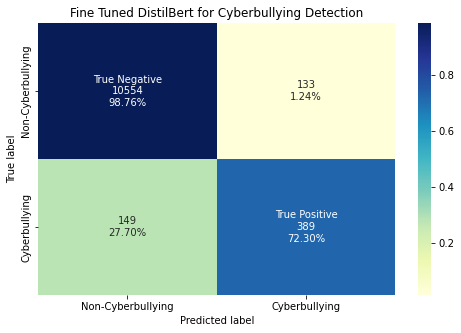

In [9]:
compute_metrics_holdout(model_name='DistilBert',
                        model_path='content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-12628', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 2

loading configuration file content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-25256/config.json
Model config DistilBertConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-25256",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.0",
  "vocab_size": 30522
}

loading weights file content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-25256/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassi

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10687
           1       0.76      0.71      0.73       538

    accuracy                           0.98     11225
   macro avg       0.87      0.85      0.86     11225
weighted avg       0.97      0.98      0.97     11225


Label 1: Cyberbullying
Precision:  0.76
Recall:  0.7063197026022305
F-measure:  0.7321772639691715

Label 0: Non-Cyberbullying
Precision:  0.9852680652680653
Recall:  0.9887714045101526
F-measure:  0.987016626190921

Macro Metrics
Precision:  0.8726340326340327
Recall:  0.8475455535561915
F-measure:  0.8595969450800462



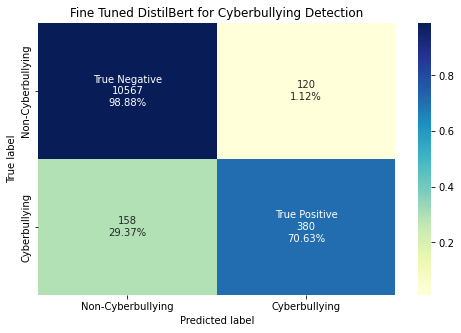

In [11]:
compute_metrics_holdout(model_name='DistilBert',
                        model_path='content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-25256', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 3

loading configuration file content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-37884/config.json
Model config DistilBertConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-37884",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.0",
  "vocab_size": 30522
}

loading weights file content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-37884/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassi

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10687
           1       0.76      0.68      0.72       538

    accuracy                           0.97     11225
   macro avg       0.87      0.84      0.85     11225
weighted avg       0.97      0.97      0.97     11225


Label 1: Cyberbullying
Precision:  0.7645833333333333
Recall:  0.6821561338289963
F-measure:  0.7210216110019646

Label 0: Non-Cyberbullying
Precision:  0.9840856212191718
Recall:  0.989426405913727
F-measure:  0.9867487868607691

Macro Metrics
Precision:  0.8743344772762525
Recall:  0.8357912698713617
F-measure:  0.8538851989313668



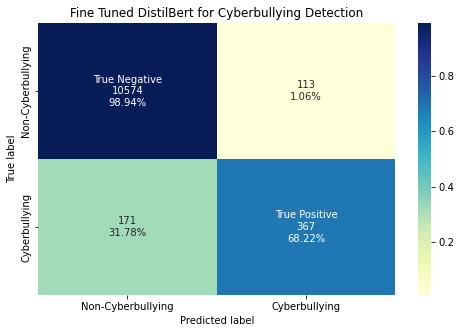

In [12]:
compute_metrics_holdout(model_name='DistilBert',
                        model_path='content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-37884', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 4

loading configuration file content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-50512/config.json
Model config DistilBertConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-50512",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.0",
  "vocab_size": 30522
}

loading weights file content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-50512/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassi

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10687
           1       0.74      0.71      0.72       538

    accuracy                           0.97     11225
   macro avg       0.86      0.85      0.86     11225
weighted avg       0.97      0.97      0.97     11225


Label 1: Cyberbullying
Precision:  0.7388781431334622
Recall:  0.7100371747211895
F-measure:  0.724170616113744

Label 0: Non-Cyberbullying
Precision:  0.9854314531191632
Recall:  0.9873678300739216
F-measure:  0.9863986912830102

Macro Metrics
Precision:  0.8621547981263127
Recall:  0.8487025023975556
F-measure:  0.8552846536983771



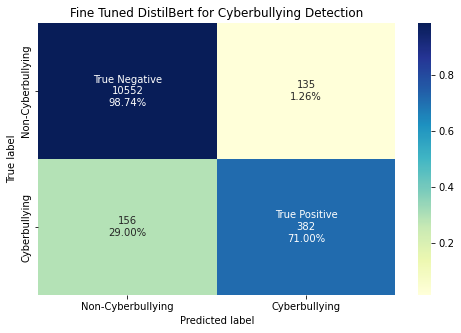

In [13]:
compute_metrics_holdout(model_name='DistilBert',
                        model_path='content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-50512', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 5

loading configuration file content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-63140/config.json
Model config DistilBertConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-63140",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.0",
  "vocab_size": 30522
}

loading weights file content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-63140/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassi

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10687
           1       0.72      0.73      0.73       538

    accuracy                           0.97     11225
   macro avg       0.86      0.86      0.86     11225
weighted avg       0.97      0.97      0.97     11225


Label 1: Cyberbullying
Precision:  0.7240740740740741
Recall:  0.7267657992565055
F-measure:  0.7254174397031541

Label 0: Non-Cyberbullying
Precision:  0.9862423958820776
Recall:  0.9860578272667727
F-measure:  0.9861501029384242

Macro Metrics
Precision:  0.8551582349780759
Recall:  0.8564118132616392
F-measure:  0.8557837713207892



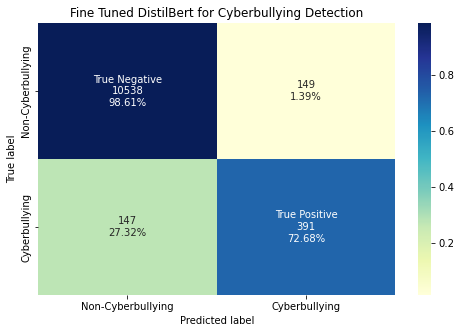

In [14]:
compute_metrics_holdout(model_name='DistilBert',
                        model_path='content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-63140', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 6

loading configuration file content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-75768/config.json
Model config DistilBertConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-75768",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.0",
  "vocab_size": 30522
}

loading weights file content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-75768/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassi

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10687
           1       0.76      0.67      0.72       538

    accuracy                           0.97     11225
   macro avg       0.87      0.83      0.85     11225
weighted avg       0.97      0.97      0.97     11225


Label 1: Cyberbullying
Precision:  0.7637130801687764
Recall:  0.6728624535315985
F-measure:  0.7154150197628457

Label 0: Non-Cyberbullying
Precision:  0.9836294298204818
Recall:  0.9895199775428091
F-measure:  0.9865659109991604

Macro Metrics
Precision:  0.873671254994629
Recall:  0.8311912155372038
F-measure:  0.850990465381003



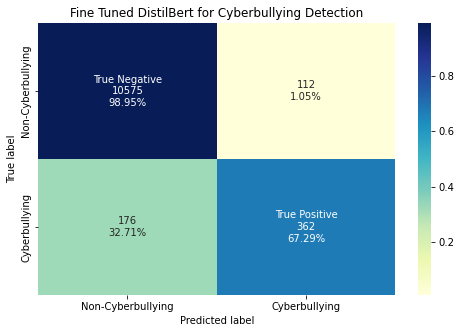

In [15]:
compute_metrics_holdout(model_name='DistilBert',
                        model_path='content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-75768', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 7

loading configuration file content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-88396/config.json
Model config DistilBertConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-88396",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.0",
  "vocab_size": 30522
}

loading weights file content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-88396/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassi

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10687
           1       0.77      0.66      0.71       538

    accuracy                           0.97     11225
   macro avg       0.88      0.83      0.85     11225
weighted avg       0.97      0.97      0.97     11225


Label 1: Cyberbullying
Precision:  0.7727272727272727
Recall:  0.6635687732342007
F-measure:  0.714

Label 0: Non-Cyberbullying
Precision:  0.9831831273808418
Recall:  0.9901749789463835
F-measure:  0.9866666666666667

Macro Metrics
Precision:  0.8779552000540572
Recall:  0.8268718760902921
F-measure:  0.8503333333333334



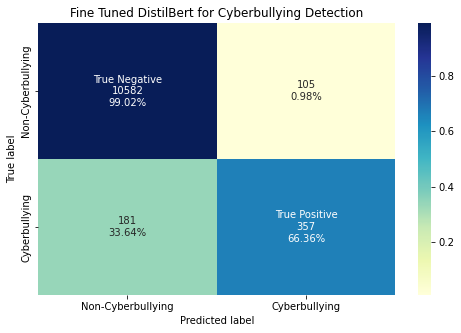

In [16]:
compute_metrics_holdout(model_name='DistilBert',
                        model_path='content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-88396', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 8

loading configuration file content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-101024/config.json
Model config DistilBertConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-101024",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.0",
  "vocab_size": 30522
}

loading weights file content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-101024/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceCla

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10687
           1       0.78      0.66      0.71       538

    accuracy                           0.97     11225
   macro avg       0.88      0.82      0.85     11225
weighted avg       0.97      0.97      0.97     11225


Label 1: Cyberbullying
Precision:  0.7827050997782705
Recall:  0.6561338289962825
F-measure:  0.7138523761375126

Label 0: Non-Cyberbullying
Precision:  0.9828290328568776
Recall:  0.9908299803499578
F-measure:  0.9868132892223102

Macro Metrics
Precision:  0.8827670663175741
Recall:  0.8234819046731201
F-measure:  0.8503328326799113



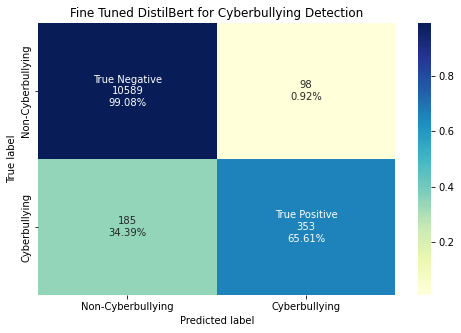

In [17]:
compute_metrics_holdout(model_name='DistilBert',
                        model_path='content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-101024', 
                        average_method='binary',
                        X_test=X_test)